# Predicting Uncertainty using Bayesian Inference with PyMC3

Most Machine Learning (ML) models return a point-estimate of the most likely data label, given an instance of feature data. There are many scenarios, however, where a point-estimate is not enough - where there is need to understand the model's uncertainty in the prediction. For example, when assessing risk, or more generally, when making decisions to optimise some organisational-level cost (or utility) function. This need is particularly acute when the cost is a non-linear function of the variable you're trying to predict.

For these scenarios, 'traditional' statistical modelling can provide access to the distribution of predicted labels, but these approaches are hard to scale and built upon assumptions that are often invalidated by the data they're trying to model. Alternatively, it is possible to train additional ML models for predicting specific quantiles, through the use of [quantile loss functions](https://towardsdatascience.com/quantile-regression-from-linear-models-to-trees-to-deep-learning-af3738b527c3), but this requires training one new model for every quantile you need to predict, which is inefficient.

Half-way between statistics and ML we have probabilistic programming, rooted in the methods of Bayesian inference. This notebook demonstrates how to train such a predictive model using [PyMC3](https://docs.pymc.io) - a Probabilistic Programming Language (PPL) for Python. We will demonstrate how a single probabilistic program can be used to support requests for point-estimates, arbitrary uncertainty ranges, as well as entire distributions of predicted data labels, for a non-trivial regression task.

## A (very) Quick Introduction to Bayesian Inference

Like statistical data analysis (and ML to some extent), the main aim of Bayesian inference is to infer the unknown parameters in a model of the observed data. For example, to test a hypotheses about the physical processes that lead to the observations. Bayesian inference deviates from traditional statistics - on a practical level - because it explicitly integrates prior knowledge regarding the uncertainty of the model parameters, into the statistical inference process. To this end, Bayesian inference focuses on the posterior distribution,

$$
p(\Theta | X) = \frac{p(X | \Theta) \cdot p(\Theta)}{p(X)}
$$

Where,

- $\Theta$ is the vector of unknown model parameters, that we wish to estimate; 
- $X$ is the vector of observed data;
- $p(X | \Theta)$ is the likelihood function, that models the probability of observing the data for a fixed choice of parameters; and,
- $p(\Theta)$ is the prior distribution of the model parameters.

The unknown model parameters are not limited to regression coefficients - Deep Neural Networks (DNNs) can be trained using Bayesian inference and PPLs, as an alternative to gradient descent - e.g., see the article by [Thomas Wiecki](https://twiecki.io/blog/2016/06/01/bayesian-deep-learning/).

If you're interested in learning more about Bayesian data analysis and inference, then an **excellent** (inspirational) and practical introduction is [Statistical Rethinking by Richard McElreath](https://xcelab.net/rm/statistical-rethinking/). For a more theoretical treatment try [Bayesian Data Analysis by Gelman & co.](http://www.stat.columbia.edu/~gelman/book/). If you're curious, read on!

## Imports

In addition to PyMC3 we are also going to rely heavily on ArviZ, which is an inference data management and visualisation package that works with many PPLs, and is tightly coupled to PyMC3.

In [1]:
import warnings

import arviz as az
import boto3 as aws
import joblib
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
from numpy.random import choice, randn, uniform
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

## Configuration

Set plot styles and suppress warning messages.

In [2]:
sns.set()
az.style.use("arviz-darkgrid")
warnings.filterwarnings("ignore")

## Create a Synthetic Dataset

To aid in building intuition for how Bayesian inference and PPLs work, we will simulate a 'toy' regression dataset using random number generation and then estimate the parameters.

For our synthetic dataset, we will assume that the dependent variable (or labelled data), $\tilde{y}$, is a linear function of a single independent variable (or feature), $x$, whose impact on $\tilde{y}$ depends on a categorical variable (or feature), $c$. We define $x$ is a positive real number and $c$ to belong to one of three categories, that occur with equal likelihood. We express this model mathematically, as follows,

$$
\tilde{y} = \beta_{c} \cdot x + \sigma \cdot \tilde{\epsilon}
$$

where $\tilde{\epsilon} \sim N(0, 1)$, $\sigma$ is the standard deviation of the random noise in the data and $c \in \{0, 1, 2\}$ denotes the category. We start by hard-coding our choices for the model parameters, that we will then try and estimate.

In [3]:
beta_c0 = 1
beta_c1 = 1.25
beta_c2 = 1.50

sigma = 0.75

Now we simulate 2,000 synthetic observations.

In [4]:
n_samples = 2000

category_to_beta_map = {0: beta_c0, 1: beta_c1, 2: beta_c2}
category = choice(3, size=n_samples)
beta_c = [category_to_beta_map[e] for e in category]
x = uniform(low=0, high=10, size=n_samples)
y = beta_c * x + sigma * randn(n_samples)

model_data = pd.DataFrame({"y": y, "x": x, "category": category})
display(model_data.head())

,y,x,category
0,4.647869,3.277546,2
1,7.924285,7.867221,0
2,7.898359,6.560159,1
3,1.674000,2.079774,1
4,10.680126,8.564657,1


And plot the full dataset, labelling each observation by the category assigned to it.

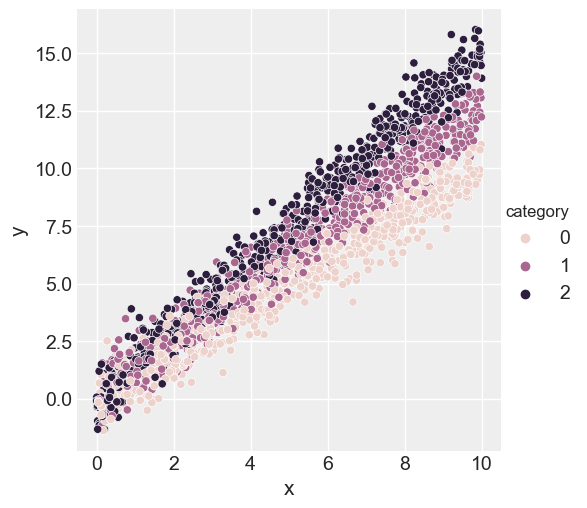

In [5]:
_ = sns.relplot(x="x", y="y", hue="category", data=model_data)

### Split Data into Training and Test Sets

One of the advantages of generating synthetic data is that we can ensure we have enough data to be able to partition it into two sets - one for training models and one for testing models. We use a helper function from the Scikit-Learn package for this task and make use of stratified sampling to ensure that we have a balanced representation of each category in both training and test datasets.

In [6]:
train, test = train_test_split(model_data, test_size=0.2, stratify=model_data.category)

## Define Model

Defining a Bayesian inference model in a PPL like PyMC3, has analogues to defining a DNN model in a tensor computing framework like PyTorch. Perhaps this is not surprising, given that PyMC3 is built upon a tensor computing framework called [Aesara](https://github.com/pymc-devs/aesara). Aesara is a fork of [Theano](https://en.wikipedia.org/wiki/Theano_(software)), a precursor of TensorFlow, PyTorch, etc.

We start by defining the variables,

```python
with model:
    y = pm.Data("y", train["y"])
    x = pm.Data("x", train["x"])
    category = pm.Data("category", train["category"])
    
    # ...
```

And then the mathematical model that encodes our hypothesis about the real-world data-generating process. This is identical to the one used to generate the data,

```python
with model:
    # ...
    
    beta_prior = pm.Normal("beta", mu=0, sd=2, shape=2)
    sigma_prior = pm.HalfNormal("sigma", sd=2, shape=1)
    mu_likelihood = beta_prior[category] * x
    obs_likelihood = pm.Normal("obs", mu=mu_likelihood, sd=sigma_prior, observed=y)
 ```

Where we have made assumptions (or educated guesses) about the [prior distribution](https://en.wikipedia.org/wiki/Prior_probability) of all the parameters in the model. Although it is beyond the scope of this notebook, it is worth mentioning that it is possible to specify prior distributions for the parameters within the prior distributions, referred to as hyper-priors. This setup is referred to as hierarchical modelling and can help defend against over-fitting to the training data, especially in the presence of high-cardinality categorical variables.

In [7]:
model = pm.Model()

with model:
    y = pm.Data("y", train["y"])
    x = pm.Data("x", train["x"])
    category = pm.Data("category", train["category"])

    beta_prior = pm.Normal("beta", mu=0, sd=2, shape=3)
    sigma_prior = pm.HalfNormal("sigma", sd=2, shape=1)
    mu_likelihood = beta_prior[category] * x
    obs_likelihood = pm.Normal("obs", mu=mu_likelihood, sd=sigma_prior, observed=y)

## Training the Model - the Bayesian Inference Step

Training the model, means inferring the posterior distribution $p(\Theta | X)$ - the probability of the parameters conditional on the observed data. PPLs use a class of algorithms known as Markov-Chain Monte Carlo (MCMC), to generate samples from the posterior distribution, thereby reconstructing it numerically. The specific type of MCMC algorithm most often used by PyMC3, is Hamiltonian Monte Carlo (HMC). If you're interested to learn a bit more about what is going on here, then we strongly recommend Michael Betancourt's [conceptual introduction to HMC](https://arxiv.org/abs/1701.02434).

The output of the inference step is basically a dataset - i.e. the collection samples for every parameter in model. You could view MCMC as the analogue of gradient descent for training DNNs, whose aim is to output a set of weights that optimise a loss function, given a model (the network).

Enough talking, let's use PyMC3 to do the inference. We are going to generate 10,000 samples of the posterior distribution - 5,000 from each core - using an initial 1,000 samples for the algorithm to settle to a steady-state (i.e. converge to the distribution).

In [8]:
with model:
    inference = pm.sample(draws=5000, tune=1000, cores=2, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 39 seconds.


### Training Diagnostics

Inference using MCMC algorithms can fail, just like training DNNs using gradient descent, can fail. MCMC algorithms can fail to converge to the posterior distribution or generate peculiar outliers. We can check for this visually by plotting the distribution of samples and the sequence of samples, for each parameter in the posterior distribution.

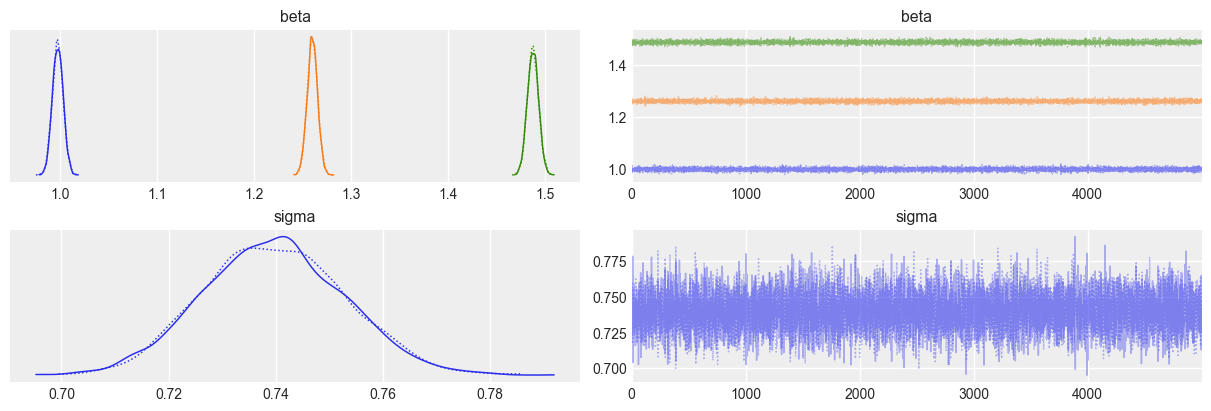

In [9]:
_ = az.plot_trace(inference)

Looks 'okay' to me 🙂 We can also generate a number of 'vital statistics'.

In [10]:
inference_summary = az.summary(inference, round_to=4)
inference_summary[['mean', 'sd', 'r_hat']]

,mean,sd,r_hat
beta[0],0.9979,0.0055,1.0000
beta[1],1.2602,0.0053,1.0000
beta[2],1.4873,0.0057,0.9999
sigma[0],0.7396,0.0131,0.9999


Here we have the the mean of each parameter distribution, together with the standard deviation and the Gelman Rubin statistic, `r_hat`. A value close to 1 for `r_hat` implies that the MCMC has converged - i.e. that training has been successful! We also have the mean (point) estimate for each parameter - note how close they are to those we used in the data generating process.

## The Posterior Predictive Distribution

The distribution of the observed data labels, $\tilde{y}$, is a point-in-time empirical estimate of the true distribution (known only to God). Our model, post-inference, allows us to estimate the uncertainty in the empirical distribution of data labels.

The output from the MCMC algorithm allows us to draw samples of the models' parameters. For each sample, we can use the model and the all instances of the feature data, to reproduce a distribution of the data labels. 

If we repeat this process and visualise it, we can then identify the regions of greatest uncertainty, based on the model. We plot the output of this process for 100 samples of the models' parameters - that is, 100 potential distributions of the data labels.

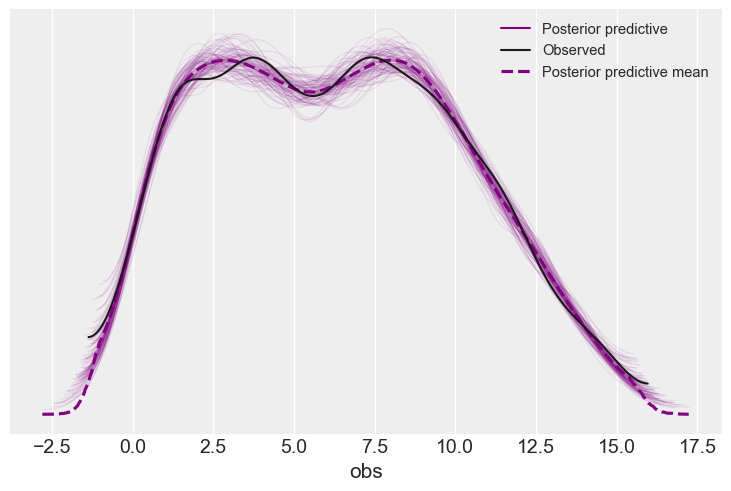

In [11]:
with model:
    posterior_predictive_samples = pm.sample_posterior_predictive(
        inference.posterior, samples=100
    )
    posterior_predictive_data = az.from_pymc3(
        posterior_predictive=posterior_predictive_samples
    )

_ = az.plot_ppc(posterior_predictive_data, color="purple", alpha=0.1)

### Aside: Monitoring Concept Drift

[Concept drift](https://en.wikipedia.org/wiki/Concept_drift) occurs when the statistical properties of the data labels, such as the distribution, change over time. When monitoring any ML model, it is important to monitor the data for concept drift, as it may signal potential degradation in the model's performance. What the plot above demonstrates, is that comparing empirical distributions for changes in their statistical properties, is complex and needs to appreciate the uncertainties intrinsic to empirical distributions.

## Test the Model

Enough statistics - we're interested in making predictions! Let's score the test data and output some performance metrics. We start by assigning the test data to our model,

```python
with model:
    pm.set_data({
        "y": test["y"],
        "x": test["x"],
        "category": test["category"]
    })

    # ...
```

We then draw 100 samples of the models' parameters as we did for the posterior predictive plot, and then use the model and the features from the **test** data, to generate a distribution of data label samples, for each instance of feature data we want to score.

```python
with model:
    # ...
    
    posterior_pred = pm.sample_posterior_predictive(
        inference.posterior, samples=100
    )
```

Most performance metrics for ML models require a point-estimate of the predicted label, not a distribution. We have chosen to compute the mean (expected) label for every set of predicted label samples, so we can compare a single prediction to the actual value and compute the Mean Absolute Percentage Error (MAPE).

mean abs. pct. error = 36.62%


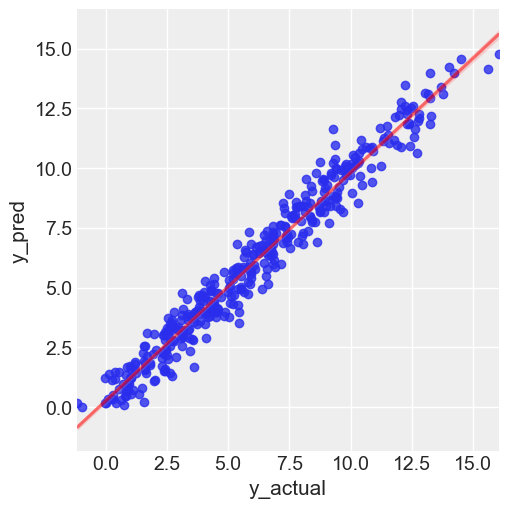

In [12]:
with model:
    pm.set_data({
        "y": test["y"],
        "x": test["x"],
        "category": test["category"]
    })
    posterior_pred = pm.sample_posterior_predictive(
        inference.posterior, samples=100
    )

predictions = np.mean(posterior_pred["obs"], axis=0)
mape = mean_absolute_percentage_error(test["y"], predictions)
print(f"mean abs. pct. error = {mape:.2%}")
    
prediction_data = pd.DataFrame({"y_pred": predictions, "y_actual": test["y"]})
_ = sns.lmplot(
    y="y_pred",
    x="y_actual",
    data=prediction_data,
    line_kws={"color": "red", "alpha": 0.5}
)

## Persist Model

Out ultimate aim is to serve predictions, so we will need to persist the model and the results of the inference from the MCMC algorithm. We can use the joblib package for the model and will persist the inference data in [NetCDF](https://en.wikipedia.org/wiki/NetCDF) format.

In [13]:
joblib.dump(model, "model_definition.joblib")
inference.to_netcdf("model_inference.nc")

'model_inference.nc'

We are also going to upload these files to cloud object storage (AWS S3), so that our prediction service can download them directly. The inference data is ~100mb in size, which is too large Git. Storing models within Git repos is not a 'best practice' either.

In [14]:
s3_client = aws.client('s3')
s3_client.upload_file(
    "model_definition.joblib",
    "bodywork-pymc3-project",
    "models/pymc.joblib"
)
s3_client.upload_file(
    "model_inference.nc",
    "bodywork-pymc3-project",
    "inference_data/pymc.nc"
)

## Test Model Artefacts

We will quickly check that our model artefacts can be successfully re-loaded from file.

In [15]:
inference_test = az.from_netcdf("model_inference.nc")
model_test = joblib.load("model_definition.joblib")

## Prototype Prediction Endpoints

Once the artefacts are loaded we can define the functions that back our API endpoints.

### Point Estimates

Based on the median of the predicted label samples.

In [16]:
def predict_point(x: float, category: int, samples: int = 100) -> float:
    """Function for scoring feature data using point estimates."""
    pm.set_data({"y": [0], "x": [x], "category": [category]}, model=model_test)
    posterior_pred = pm.sample_posterior_predictive(
        inference_test.posterior,
        model=model_test,
        samples=samples,
        random_seed=42,
        progressbar=False
    )
    point_estimate = np.median(posterior_pred["obs"].reshape(-1,))
    return {'y': point_estimate, 'samples': samples}

In [17]:
predict_point(3.5, 1)

{'y': 4.308875506569684, 'samples': 100}

### Highest Density Interval

The range of predicted labels, corresponding to the narrowest interval with the requested probability mass.

In [18]:
def predict_hdi(
    x: float,
    category: int,
    hdi_prob: float = 0.95,
    samples: int = 100
) -> float:
    """Function for scoring feature data using credible intervals."""
    pm.set_data({"y": [0], "x": [x], "category": [category]}, model=model_test)
    posterior_pred = pm.sample_posterior_predictive(
        inference_test.posterior,
        model=model_test,
        samples=samples,
        random_seed=42,
        progressbar=False
    )
    hdi = pm.hdi(posterior_pred["obs"].reshape(-1,), hdi_prob=hdi_prob)
    return {'lower': hdi[0], 'upper': hdi[1], 'hdi_prob': hdi_prob, 'samples': samples}

In [19]:
predict_hdi(3.5, 1, 0.95)

{'lower': 2.956663552229616,
 'upper': 5.562126722976245,
 'hdi_prob': 0.95,
 'samples': 100}

### Density

The distribution of predicted label samples.

In [20]:
def predict_density(
    x: float,
    category: int,
    bins: int = 10,
    samples: int = 100
) -> float:
    """Function for scoring feature data using probability density."""
    pm.set_data({"y": [0], "x": [x], "category": [category]}, model=model_test)
    posterior_pred = pm.sample_posterior_predictive(
        inference_test.posterior,
        model=model_test,
        samples=samples,
        random_seed=42,
        progressbar=False
    )
    density, bin_edges = np.histogram(
        posterior_pred["obs"].reshape(-1,), bins=bins, density=True
    )
    bin_mids = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    return {'bin_mids': bin_mids, 'density': density, 'samples': samples}

In [21]:
predict_density(3.5, 1, 5)

{'bin_mids': array([2.79928527, 3.47106466, 4.14284404, 4.81462342, 5.4864028 ]),
 'density': array([0.08931504, 0.19351591, 0.58054774, 0.46146102, 0.16374423]),
 'samples': 100}